In [1]:
# import libraries we need
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

Populating the interactive namespace from numpy and matplotlib


*This is for simulating correlation data using Monte Carlo.*

First, we make random choice to decide which light source is used.

'\nsingle photon source -> event 0\nthermal source -> event 1\nnothing detected -> event 2\n'

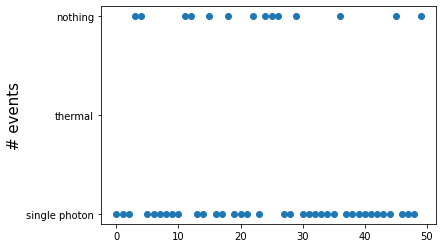

In [2]:
# determine which the light source for each detection

Ndetection = 50    # number of detections
p_sps = 0.70         #  probability of detecting a single photon source
p_thermal = 0.0      # probability of detecting a thermal light source
p_non = 0.30          # probability of getting nothing / 2nd photon is not in the range of abs time range
source = tf.random.categorical(tf.math.log([[p_sps,p_thermal,p_non]]), Ndetection)
plt.scatter(np.arange(Ndetection),source[0])
plt.ylabel('# events',fontsize=15)
plt.yticks([0,1,2],['single photon','thermal','nothing'])
'''
single photon source -> event 0
thermal source -> event 1
nothing detected -> event 2
'''


---

Next, we simulate the single photon source case.

In [416]:
uni_dist.prob(-201)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

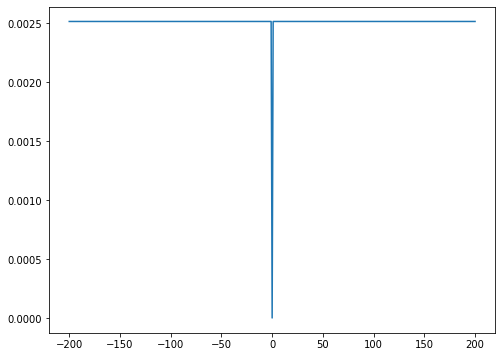

In [393]:
total_bin = 400     # number of total time bins
bin_array = tf.range(-1 * total_bin//2,total_bin//2+1,delta=1,dtype=float32)

tbin_n = tf.constant(np.linspace(min(bin_array),-1,total_bin//2),dtype=float32)
tbin_p = tf.constant(np.linspace(1,max(bin_array),total_bin//2),dtype=float32)

uni_dist = tfd.MixtureSameFamily(
    mixture_distribution = 
    tfd.Categorical(probs=[tbin_n.shape[0]/total_bin,0, tbin_p.shape[0]/total_bin]),
    
    components_distribution = 
    tfd.Uniform(low=[min(bin_array),-1,1],high=[-1,1,max(bin_array)])
                       )

uni_prob = uni_dist.prob([tbin_n,tbin_p])
uni_prob = tf.concat([uni_prob[0],[0],uni_prob[1]],0)
plt.plot(bin_array,uni_prob)
#plt.xlim(-2,2)
plt.show()


In [440]:
counts = 10e6
samples = tf.cast(uni_dist.sample(counts),dtype=int32)

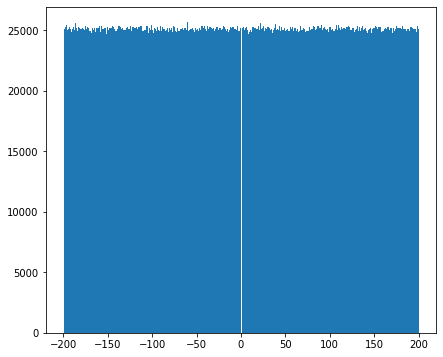

In [445]:
plt.figure(figsize(7,6))
bin_info=plt.hist(samples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) )   #np.ndarray.tolist(bin_array.numpy()) )
#plt.xlim(-200,-150)

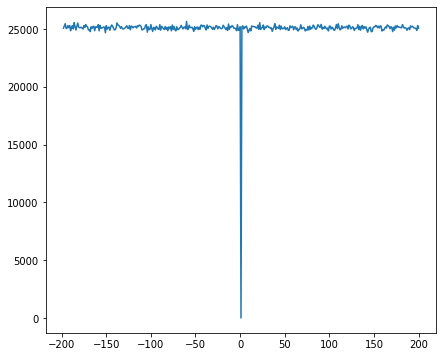

In [451]:
plt.plot(bin_info[1][2:],bin_info[0][1:])

### check plt.hist

In [431]:
min(bin_info[1],bin_info[0])

ValueError: operands could not be broadcast together with shapes (400,) (401,) 

In [447]:
bin_info

(array([1.0000e+00, 2.5082e+04, 2.5273e+04, 2.5469e+04, 2.5050e+04,
        2.5087e+04, 2.5302e+04, 2.5126e+04, 2.5308e+04, 2.4867e+04,
        2.5121e+04, 2.5298e+04, 2.5015e+04, 2.5560e+04, 2.5213e+04,
        2.4924e+04, 2.5235e+04, 2.5529e+04, 2.5195e+04, 2.5121e+04,
        2.5124e+04, 2.5168e+04, 2.5087e+04, 2.5007e+04, 2.5309e+04,
        2.5138e+04, 2.5390e+04, 2.5242e+04, 2.5191e+04, 2.4926e+04,
        2.4969e+04, 2.4790e+04, 2.5205e+04, 2.5054e+04, 2.5215e+04,
        2.5250e+04, 2.4861e+04, 2.5193e+04, 2.5182e+04, 2.5143e+04,
        2.5384e+04, 2.4852e+04, 2.5324e+04, 2.5081e+04, 2.5094e+04,
        2.5125e+04, 2.5190e+04, 2.5159e+04, 2.4689e+04, 2.5300e+04,
        2.4997e+04, 2.5151e+04, 2.5169e+04, 2.4902e+04, 2.5185e+04,
        2.5354e+04, 2.5263e+04, 2.5098e+04, 2.4927e+04, 2.4956e+04,
        2.5119e+04, 2.5531e+04, 2.5369e+04, 2.5319e+04, 2.5222e+04,
        2.5073e+04, 2.5216e+04, 2.5049e+04, 2.5010e+04, 2.5041e+04,
        2.5102e+04, 2.5199e+04, 2.5294e+04, 2.50

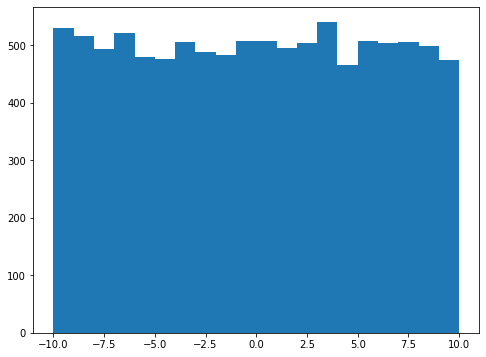

In [306]:
x=np.random.uniform(low=-10,high=10,size=10000)
k=plt.hist(x,bins=np.ndarray.tolist(np.arange(-10,11) ))

In [307]:
k

(array([529., 516., 493., 522., 480., 476., 505., 488., 483., 507., 507.,
        495., 503., 540., 465., 507., 504., 506., 499., 475.]),
 array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 <BarContainer object of 20 artists>)

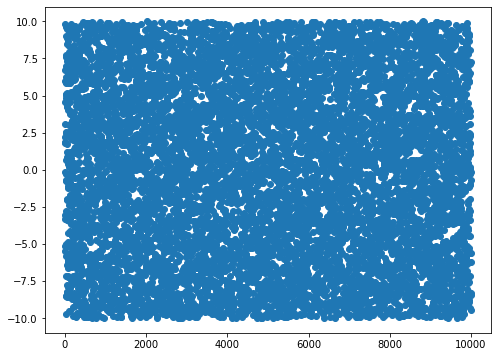

In [309]:
plt.scatter(np.arange(10000),x)

<ipython-input-82-b635f719bac8>:1: DeprecationWarning: This function is deprecated. Please call randint(2, 10 + 1) instead
  x1=np.random.random_integers(low=2,high=10,size=100)


(array([ 7.,  6., 10., 12., 12., 11., 13., 29.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 8 artists>)

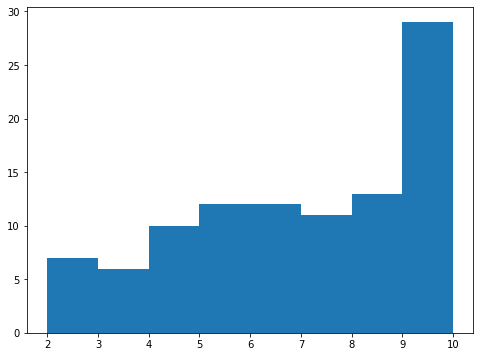

In [82]:
x1=np.random.random_integers(low=2,high=10,size=100)
plt.hist(x1,bins=8)

In [135]:
int(-200.3)

-200

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions

# Define a single scalar Normal distribution.
dist = tfd.Normal(loc=0., scale=3.)

# Evaluate the cdf at 1, returning a scalar.
dist.cdf(1.)

# Define a batch of two scalar valued Normals.
# The first has mean 1 and standard deviation 11, the second 2 and 22.
dist = tfd.Normal(loc=[-2, 2.], scale=[1.,1])

# Evaluate the pdf of the first distribution on 0, and the second on 1.5,
# returning a length two tensor.
dist.prob([-2.,2])

# Get 3 samples, returning a 3 x 2 tensor.
#dist.sample([5])


In [ ]:
# samples has shape [1, 5], where each value is either 0 or 1 with equal
# probability.
samples = tf.random.categorical([[pthermal,psps,pnon]], 50)
plt.scatter(np.arange(50),samples[0])

In [ ]:
samples.numpy()